In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from examples.SMO.turbo import train_turbo, get_initial_points, TurboState
from uncertaintylearning.utils.networks import create_optimizer, create_network
import torch
import os
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
features = 'xv'
dim = 10
batch_size = 1
n_init = 20
use_log_unc = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")
low, up = -10, 15
fun = Ackley(dim=10, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(low)
fun.bounds[1, :].fill_(up)
dim = fun.dim
lb, ub = fun.bounds

X_test = get_initial_points(dim, 1000)


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [13]:
def transform_results(res):
    return np.maximum.accumulate(res, 1)

def plot_all(seed):
    for k, v in {
                'gp': gp_results[:1 + seed, :],
                'turbo_gp': turbo_gp_results[:1 + seed, :],
                'deup_vd': deup_vd_results[:1 + seed, :],
                'turbo_deup_vd': turbo_deup_vd_results[:1 + seed, :],
                'deup_xv': deup_xv_results[:1 + seed, :],
    }.items():
        plt.errorbar(range(v.shape[1]), np.mean(v, axis=0), np.std(v, axis=0), label=k)
    plt.legend()
    plt.show()

seed 0 , gp current max -13.478581428527832


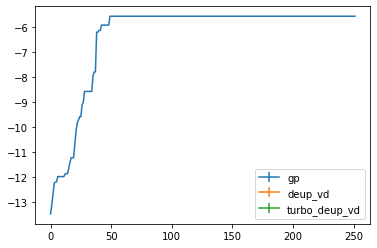

seed 1 , gp current max -14.354255676269531


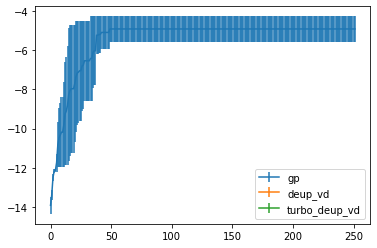

seed 2 , gp current max -14.808502197265625


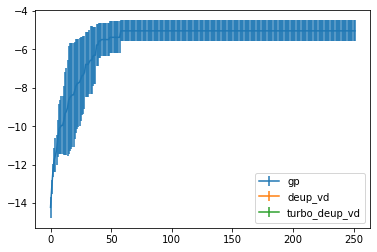

In [16]:
n_seeds = 3
max_step = 250
gp_results = np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf'))
turbo_gp_results = np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf'))
deup_v_results = np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf'))
deup_xv_results = np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf'))
turbo_deup_v_results = np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf'))

for seed in range(n_seeds):
    X_turbo = get_initial_points(dim, n_init)
    Y_turbo = torch.tensor(
        [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
    ).unsqueeze(-1)
    
    print('seed', seed, ', gp current max', Y_turbo.max().item())
    gp_results[seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=False)
    gp_results[seed, 1:len(best_values) + 1] = best_values
    plot_all(seed)
    
    print('seed', seed, ', turbo gp current max', Y_turbo.max().item())
    turbo_gp_results[seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=True)
    turbo_gp_results[seed, 1:len(best_values) + 1] = best_values
    plot_all(seed)
    
    print('seed', seed, ', deup-v current max', Y_turbo.max().item())
    deup_v_results[seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='v', turbo=False)
    deup_v_results[seed, 1:len(best_values) + 1] = best_values
    plot_all(seed)
        
    print('seed', seed, ', deup-xv current max', Y_turbo.max().item())
    deup_xv_results[seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='xv', turbo=False)
    deup_xv_results[seed, 1:len(best_values) + 1] = best_values
    plot_all(seed)
    
    print('seed', seed, ', turbo-deup-v current max', Y_turbo.max().item())
    turbo_deup_v_results[seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='v', turbo=True)
    turbo_deup_v_results[seed, 1:len(best_values) + 1] = best_values
    plot_all(seed)


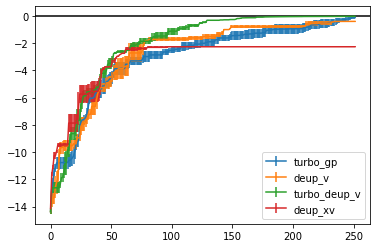

In [9]:
res = {
                'gp': gp_results[:1 + seed, :],
                'turbo_gp': turbo_gp_results[:1 + seed, :],
                'deup_v': deup_v_results[:1 + seed, :],
                'turbo_deup_v': turbo_deup_v_results[:1 + seed, :],
                'deup_xv': deup_xv_results[:seed, :],            }
for k, v in res.items():
        plt.errorbar(range(v.shape[1]), np.mean(v, axis=0), .5 * np.std(v, axis=0), label=k)
plt.legend()
plt.axhline(0, label='true max', color='k')
plt.show()

In [23]:
import pickle
pickle.dump(res, open('pickles/turbodeup.pkl', 'wb'))

In [24]:
import pickle
res = pickle.load(open('pickles/turbodeup.pkl', 'rb'))

In [19]:
res['turbo_gp'].shape

(3, 252)

In [25]:
res.keys()

dict_keys(['turbo_gp', 'deup_v', 'turbo_deup_v', 'deup_xv', 'gp'])